## Ejemplo de uso para:
### 1. crear sample points dentro de un polígono
### 2. Entrenar un PCA y KMeans clustering automaticamente
### 3. predecir en mapa

Requiere clonar el repositorio: https://github.com/JavierLopatin/Python-Remote-Sensing-Scripts.git

Y colocar los sigientes scripts en la careta donde estan trabajando: 
    stratified_points_in_polygon.py
    train_cluster.py
    apply_cluster.py



In [68]:
# For testing inside the Datacube Platform!
%matplotlib inline
%load_ext autoreload
%autoreload 2
import datacube
import numpy as np
import sys
import xarray as xr
import matplotlib.pyplot as plt
# from datacube.utils.masking import make_mask, mask_invalid_data, describe_variable_flags
from datacube.utils.rio import configure_s3_access
from dask.distributed import Client
import geopandas as gpd
import rioxarray as rio

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from yellowbrick.cluster import SilhouetteVisualizer

client = Client()
client

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/env/lib/python3.8/site-packages/distributed/node.py:179: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 44927 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:44927/status,
Dashboard: http://127.0.0.1:44927/status,Workers: 4
Total threads: 8,Total memory: 28.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:46701,Workers: 4
Dashboard: http://127.0.0.1:44927/status,Total threads: 8
Started: Just now,Total memory: 28.00 GiB
Comm: tcp://127.0.0.1:43335,Total threads: 2
Dashboard: http://127.0.0.1:33207/status,Memory: 7.00 GiB
Nanny: tcp://127.0.0.1:39803,


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


<AxesSubplot:>

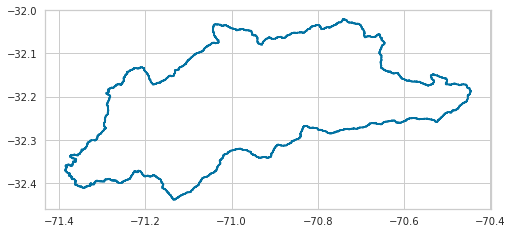

In [17]:
poly = gpd.read_file('petorca_line.shp')
poly.plot()

In [24]:
poly.geometry

0    LINESTRING Z (-70.67403 -32.06236 0.00000, -70...
1    LINESTRING Z (-70.67403 -32.06236 0.00000, -70...
Name: geometry, dtype: geometry

<AxesSubplot:>

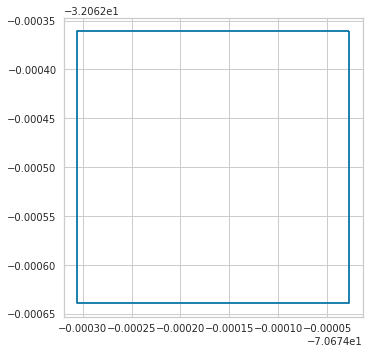

In [25]:
poly.loc[[0],'geometry'].plot() # hay que eliminar la geometria 0

<AxesSubplot:>

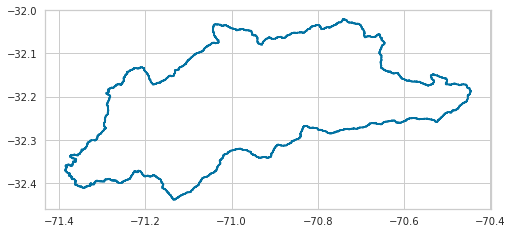

In [23]:
poly.loc[[1],'geometry'].plot() # hay que eliminar la geometria 0

In [29]:
poly.drop([0], inplace=True)
poly.geometry

1    LINESTRING Z (-70.67403 -32.06236 0.00000, -70...
Name: geometry, dtype: geometry

In [35]:
# generate stratified random points inside the polygon
import stratified_points_in_polygon

df = stratified_points_in_polygon.random_points_in_polygon(shp, number=1000, dist=10,
                                                           maxiter=5000, n_jobs=8)


100%|██████████| 1000/1000 [04:36<00:00,  3.62it/s]


<AxesSubplot:>

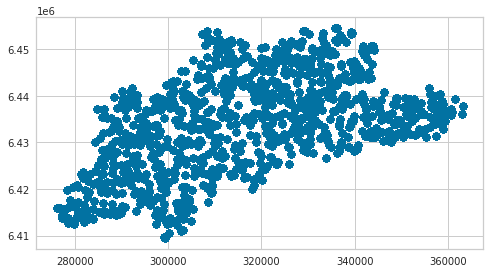

In [37]:
df.plot()

In [40]:
# cargar imágen
# datos de ejemplo que ya tengo en disco. Se puede usar imagen cargada de Data Cube también
img = rio.open_rasterio('phenopetorcaWGS84.tif')#, chunks={'y':250, 'x':250}) img

<AxesSubplot:>

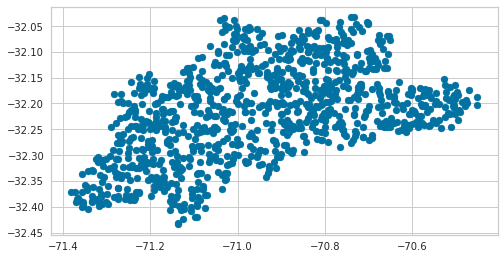

In [46]:
# si tienen los puntos generados de antemano, se pueden cargar
df = gpd.read_file('samplepoints.shp')
df.plot()

In [47]:
# revisar las coordenadas del poligono y el raster
print(df.crs) # CRS = 4326
print(img.rio.crs) # CRS = 32719. Para el raster se debe usar rio

epsg:4326
EPSG:32719


In [49]:
df = df.to_crs(32719) # cambiar CRS a 32719
df.crs

<Projected CRS: EPSG:32719>
Name: WGS 84 / UTM zone 19S
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 72°W and 66°W, southern hemisphere between 80°S and equator, onshore and offshore. Argentina. Bolivia. Brazil. Chile. Colombia. Peru.
- bounds: (-72.0, -80.0, -66.0, 0.0)
Coordinate Operation:
- name: UTM zone 19S
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [10]:
# el poligono tiene otro CRS. Se puede guardar el nuevo de ser necesario
# shp.to_file('samplepoint_projected.geojson')

In [50]:
# extract point values
from rasterstats import point_query

# N° of bands
bands = len(img.band)

# si estan los datos ya en el disco, se puede cargar el nombre y dir
extract = np.empty((len(df), bands), dtype=object) # matris para almacenar datos

# iterar en bandas y extraer valores
for i in range(bands):
    vals = point_query(df.geometry,
                      img.values[i,:,:],  # datos como array
                      affine=img.rio.transform(), # acá van las coordenadas, etc.
                      nodata=-999)
    extract[:,i] = vals


In [56]:
extract # esto se puede pasar a pandas, poner nombre en columnas, etc. 

array([[0.16839137881930066, 0.16992383211465428, 0.17516220503808091,
        ..., 0.1994228625349576, 0.1826468392973717, 0.21302716631263124],
       [0.17627534853362117, 0.1932618836675557, 0.1929869076313972, ...,
        0.20410255488074275, 0.21589123914016664, 0.21783728789195556],
       [0.10360270777497642, 0.08852505182992719, 0.08621859602105342,
        ..., 0.08189131519248212, 0.07746983699654693,
        0.08236228080985576],
       ...,
       [0.35973179278145356, 0.35973179278145356, 0.3708307563568528,
        ..., 0.40971401717893374, 0.37156240605868546, 0.429915442668487],
       [0.1996197162791647, 0.22852292527327542, 0.21230718042524843,
        ..., 0.2412560249204988, 0.20369312858043992, 0.2715729140995629],
       [0.06613734473515095, 0.05864753723150715, 0.05937547692655406,
        ..., 0.049845185178177834, 0.051540912675337704,
        0.053341715512136574]], dtype=object)

In [52]:
extract.shape

(1000, 52)

In [64]:
extract = extract.astype('float64')

In [65]:
## train PCA
import train_cluster

# img.values = img.values.astype('float64') # si se quiere entrenar con toda la imagen usar despues img_flat.values
# img_flat = img.stack(z=('y', 'x'))
# img_flat = img_flat.transpose('z', 'band')
      
std, pca, X_pca = train_cluster.test_PCA(extract) # usar extract enves de img_flat.values para usar sólo los puntos y no toda la imagen

Cumulative PCA variance: 
    n_comp    cumsum
0      1.0  0.548374
1      2.0  0.669137
2      3.0  0.754195
3      4.0  0.834174
4      5.0  0.891440
5      6.0  0.923512
6      7.0  0.942614
7      8.0  0.957889
8      9.0  0.968729
9     10.0  0.976169
10    11.0  0.980669
11    12.0  0.984793
12    13.0  0.988251
13    14.0  0.991045
14    15.0  0.992705
15    16.0  0.994044
16    17.0  0.995099
17    18.0  0.996116
18    19.0  0.996921
19    20.0  0.997631
20    21.0  0.998158
21    22.0  0.998626
22    23.0  0.998916
23    24.0  0.999111
24    25.0  0.999291
25    26.0  0.999422
26    27.0  0.999530
27    28.0  0.999624
28    29.0  0.999697
29    30.0  0.999767
30    31.0  0.999810
31    32.0  0.999846
32    33.0  0.999873
33    34.0  0.999893
34    35.0  0.999911
35    36.0  0.999928
36    37.0  0.999942
37    38.0  0.999953
38    39.0  0.999963
39    40.0  0.999971
40    41.0  0.999979
41    42.0  0.999985
42    43.0  0.999990
43    44.0  0.999994
44    45.0  0.999996
45    46

Please enter your selected number of components:  6


Processing clusters...


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


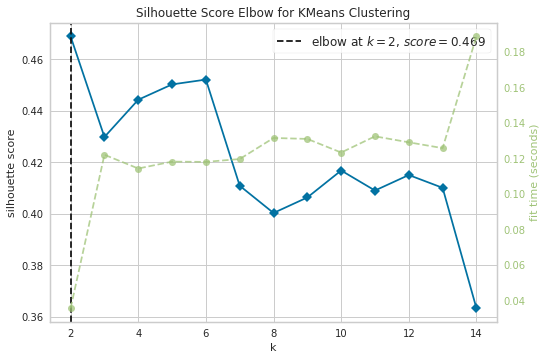

Please enter your selected number of clusters:  6


In [66]:
# test clusters
cluster = train_cluster.test_cluster(X_pca)

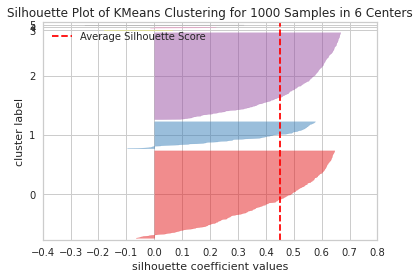

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 1000 Samples in 6 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [70]:
# test silhuette
cluster = KMeans(n_clusters = 6, random_state=42)

sil_visualizer = SilhouetteVisualizer(cluster)
sil_visualizer.fit(X_pca)    
sil_visualizer.show()

In [71]:
# save pipeline with best models
model = Pipeline([('std', std), ('pca', pca), ('cluster', cluster)])
model

Pipeline(steps=[('std', StandardScaler()), ('pca', PCA(n_components=6)),
                ('cluster', KMeans(n_clusters=6, random_state=42))])

In [ ]:
## predict on raster

In [72]:
import apply_cluster

predict = apply_cluster.process(img, model, save=False)

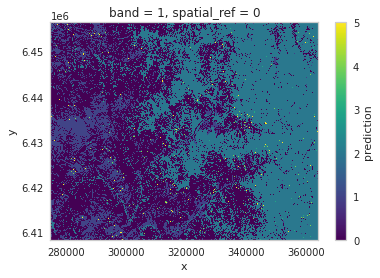

In [73]:
predict.plot()